# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="C:/Users/freed/codes_in_c_disk/deep-reinforcement-learning-master_origin/deep-reinforcement-learning-master/p3_collab-compet/Tennis_Windows_x86_64/Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations

# CAUTION:state_size here must be states.shape[1]
# since states are stored: # of agents x # of states for each agent
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
states.shape[0]

2

### 3. Program

In [6]:
from ddpg_agent import Agent
import copy
# here try to regard the agent as the multi-agent system
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

def ddpg(n_episodes=3000, max_t=1000, print_every=100):
    
    scores_deque = deque(maxlen=print_every)
    scores = []
    aver_scores = []
    flag = 0
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        stateA = env_info.vector_observations[0]               # get the current state (for each agent)
        stateB = env_info.vector_observations[1]
        
        agent.reset()
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            
            actionA = agent.act(stateA,agent_index=0)
            actionB = agent.act(stateB,agent_index=1)
            
            # For random policy,
            #actions = np.random.randn(num_agents, action_size)   # select an action (for each agent)
            
            actions = np.concatenate((actionA, actionB))
            env_info = env.step(actions)[brain_name]              # send all actions to tne environment
            
            # remove [0] for multiple agents
            next_stateA = env_info.vector_observations[0]         # get next state (for each agent)
            next_stateB = env_info.vector_observations[1]         
            
            rewards = env_info.rewards
            rewardA = rewards[0]                         # get reward (for each agent)
            rewardB = rewards[1]                         
            dones = env_info.local_done
            doneA = dones[0]                        # see if episode finished
            doneB = dones[1]                        
            
            agent.step(stateA, actionA, rewardA, next_stateA, doneA,t,agent_index=0)
            agent.step(stateB, actionB, rewardB, next_stateB, doneB,t,agent_index=1)
            
            score += env_info.rewards                          # update the score (for each agent)
            stateA = next_stateA                               # roll over states to next time step
            stateB = next_stateB                               
            
            if np.any(dones):                              # exit loop if episode finished
                break    
            
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        aver_scores.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, 
                                                           np.mean(scores_deque)), end="")
            
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, 
                                                               np.mean(scores_deque)))
        if np.mean(scores_deque)>=0.5:
            if flag == 0:
                i_episode_rec = copy.deepcopy(i_episode)
                flag = 1
                torch.save(agent.actorA_local.state_dict(), 'checkpoint_actorA.pth')
                torch.save(agent.actorB_local.state_dict(), 'checkpoint_actorB.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                
            if i_episode > i_episode_rec + 100:
                break
            
    return scores,aver_scores

scores,aver_scores = ddpg()


C:\Users\freed\AppData\Roaming\Python\Python36\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.04
Episode 400	Average Score: 0.03
Episode 500	Average Score: 0.04
Episode 600	Average Score: 0.06
Episode 700	Average Score: 0.07
Episode 800	Average Score: 0.07
Episode 900	Average Score: 0.10
Episode 1000	Average Score: 0.09
Episode 1100	Average Score: 0.13
Episode 1200	Average Score: 0.13
Episode 1300	Average Score: 0.12
Episode 1400	Average Score: 0.19
Episode 1500	Average Score: 0.26
Episode 1600	Average Score: 0.41
Episode 1700	Average Score: 0.40
Episode 1800	Average Score: 0.55
Episode 1836	Average Score: 0.59

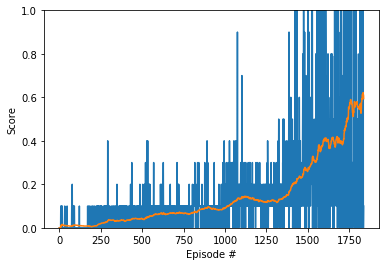

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), aver_scores)
ax.set_ylim([0,1])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env.close()